In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import dill

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
warnings.filterwarnings('ignore')

# Data Preporation

In [3]:
# Загрузка данных
data = pd.read_excel('data/main_data.xlsx', header=1)
data.drop(columns=data.columns[6], inplace=True)

# Преобразование значений к числовым
cols = ['Loan issued', 'Earned interest', 'Unpaid,  full amount']
for col in cols:
    data[col] = data[col].apply(lambda s: ''.join(re.findall('\d+', s))).astype(int)

# Расчет профита
data['Loss'] = data['Unpaid,  full amount'] * data['EL']
data['InvestorProfit'] = data['Earned interest'] - data['Loss']
data['Profit'] = data['InvestorProfit'] + data['Loan issued'] * data['Comission, %']
data['Profit, %'] = data['Profit'] / data['Loan issued'] * 100

In [4]:
data

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,Loss,InvestorProfit,Profit,"Profit, %"
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,12942.750,198108.250,366118.250,11.549472
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,0,0,0,0,0,0,28951.800,10566.200,43066.200,8.613240
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,143510.790,394169.210,916209.575,7.897748
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,0,1,0,0,0,42870.330,190151.670,426401.670,8.121937
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0.000,216485.000,328985.000,10.966167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015,0,0,0,0,...,0,0,0,0,0,0,48096.540,34965.460,238965.460,7.965515
528,6560000,10,0.0530,250635,4309425,0.015,0,0,0,0,...,0,0,0,0,0,0,64641.375,185993.625,533673.625,8.135269
529,2844671,14,0.0550,233514,1064981,0.400,0,0,0,0,...,0,0,0,0,0,0,425992.400,-192478.400,-36021.495,-1.266280
530,500000,12,0.0550,13235,414705,0.015,0,0,0,0,...,0,0,0,0,0,0,6220.575,7014.425,34514.425,6.902885


In [5]:
# Подготовка датасета
drop_cols = [
    'Loan issued',
    'Рейтинг',
    'Comission, %',
    'Earned interest',
    'Unpaid,  full amount',
    'EL',
    'Loss',
    'InvestorProfit',
    'Profit'
]
data.drop(columns=drop_cols, inplace=True)

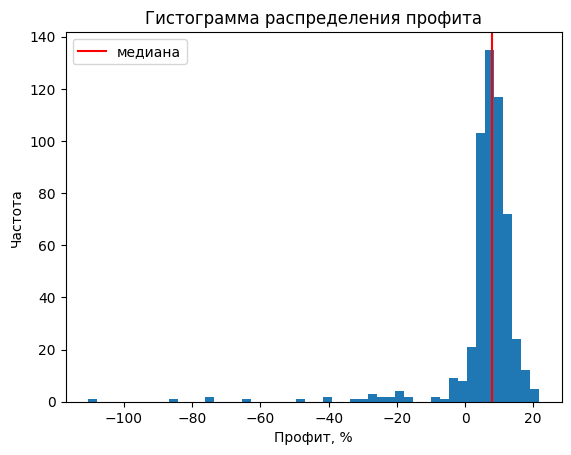

In [6]:
# Посмотрим на распределение признаков
plt.hist(data['Profit, %'], bins=50)
plt.axvline(x=data['Profit, %'].median(), c='r', label='медиана')
plt.xlabel('Профит, %')
plt.ylabel('Частота')
plt.title('Гистограмма распределения профита')
plt.legend()
plt.show()

In [7]:
thr = data['Profit, %'].median()
print(f'Медиана признака Profit: {thr} %')

Медиана признака Profit: 7.942897666666667 %


1. Будем считать, что займ выдавать целесообразно, если профит превышает медианное значение (7.9 %)
2. Метка класса "1" означает, что займ можно выдавать, метка класса "0" означает, что займ выдавать не стоит.
2. В процессе тюнинга параметров моделей машинного обучение будем стараться максимизировать precision_score, чтобы уменьшить число ложноположительных предсказаний (одобрение невыгодных займов).

In [8]:
X = data.drop(columns=['Profit, %'])
y = (data['Profit, %']>=thr).astype(int)

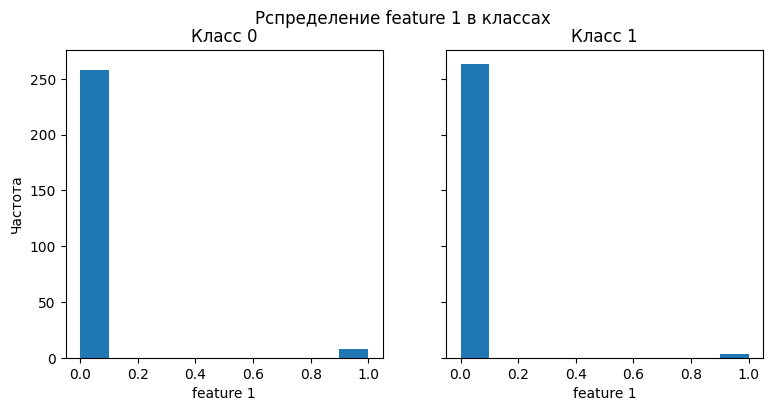

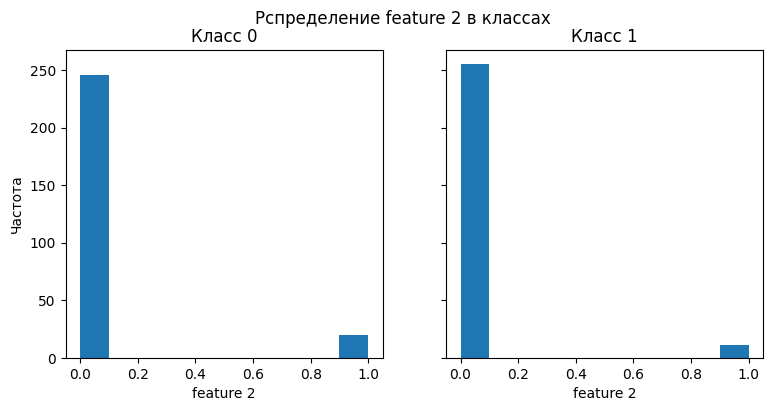

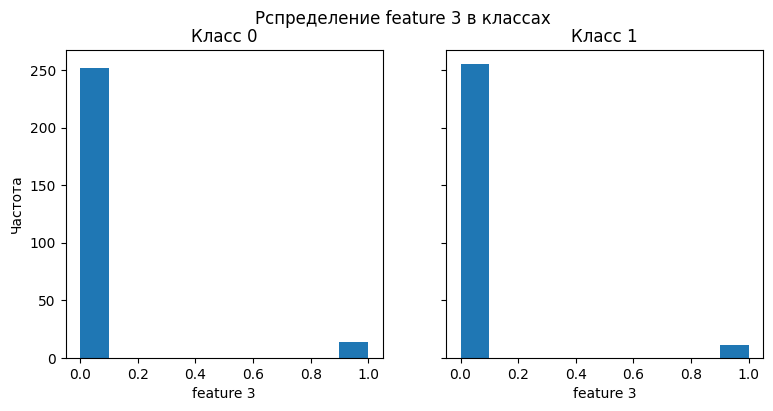

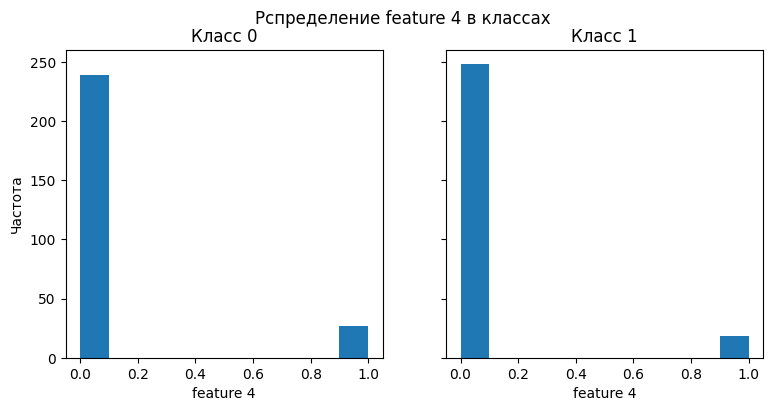

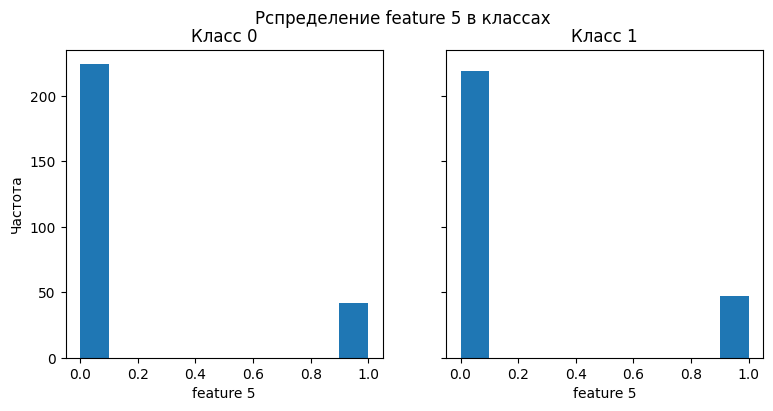

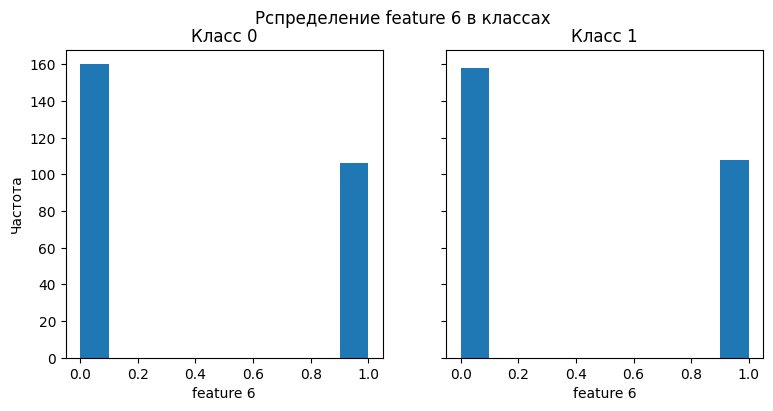

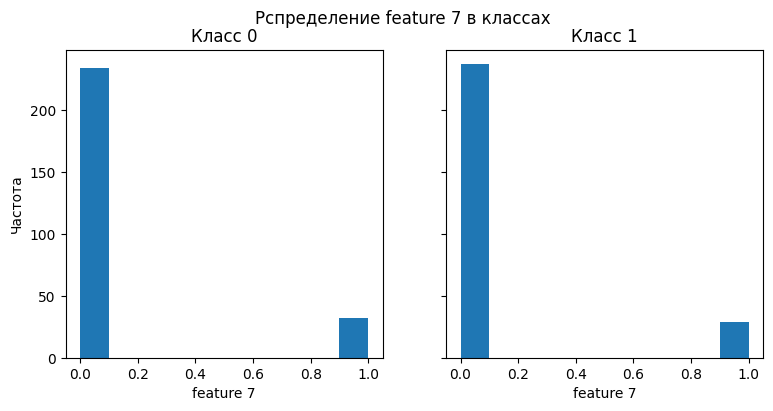

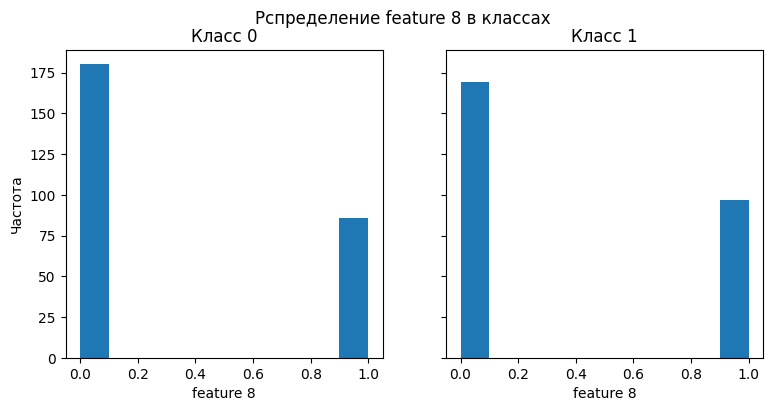

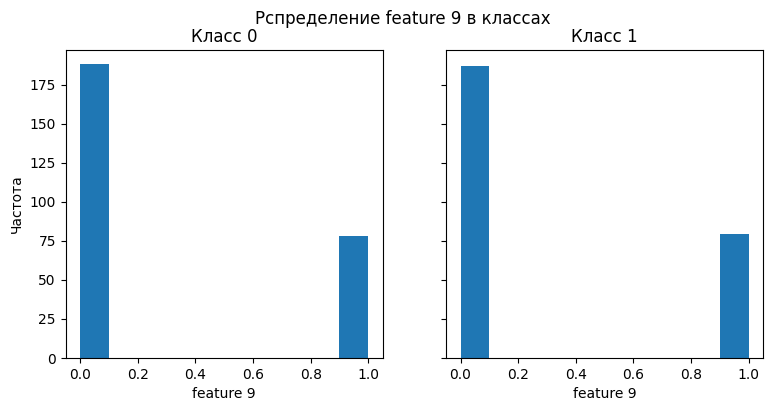

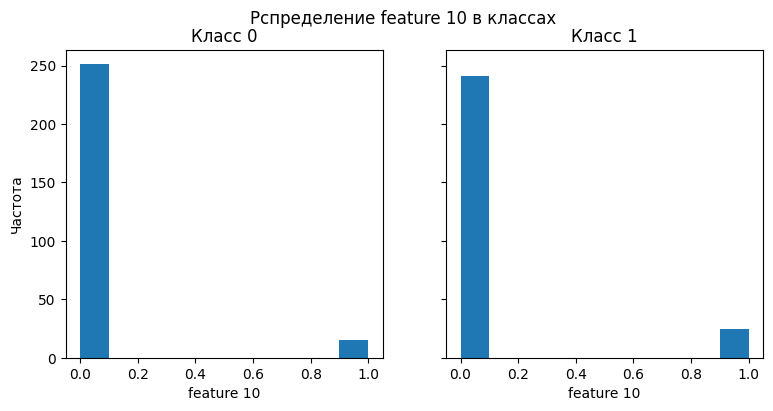

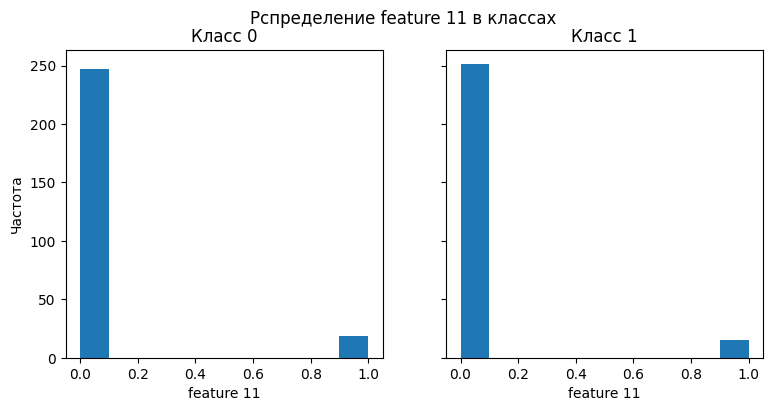

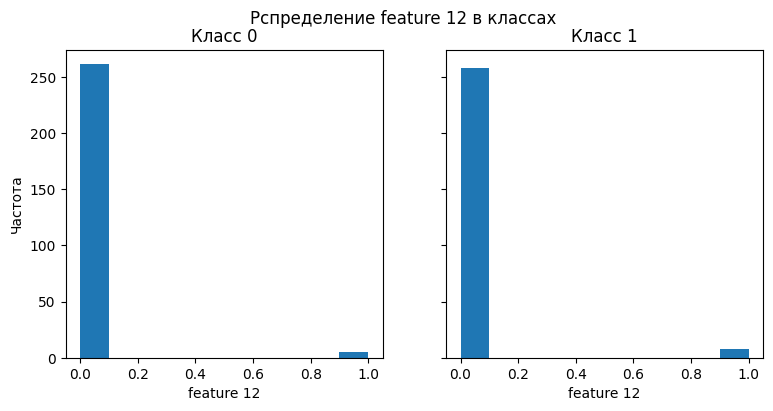

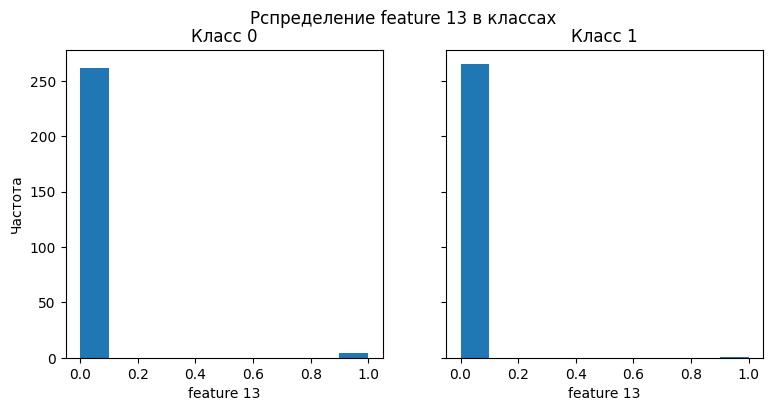

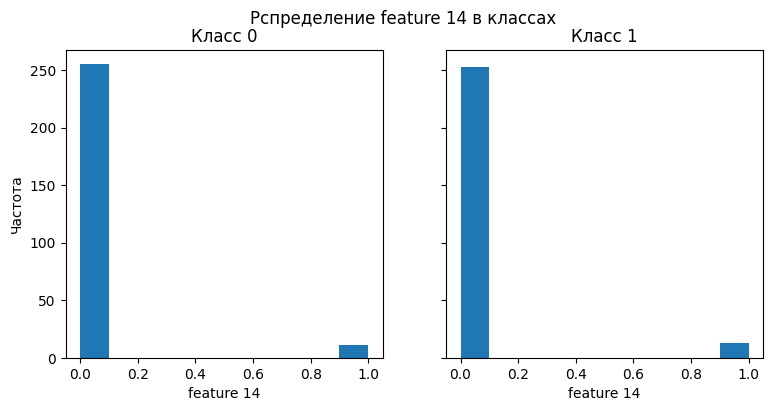

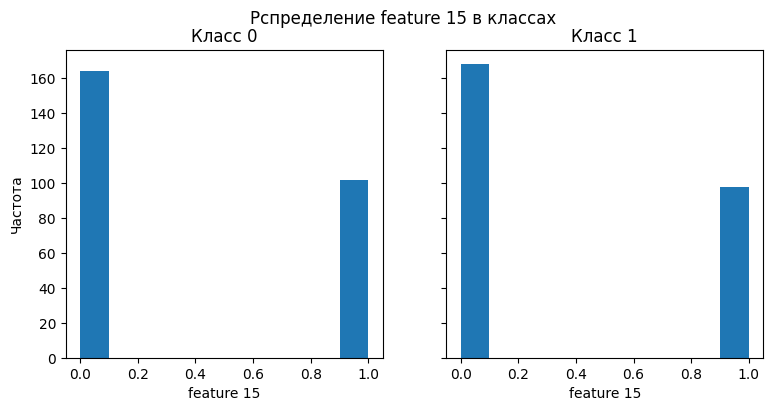

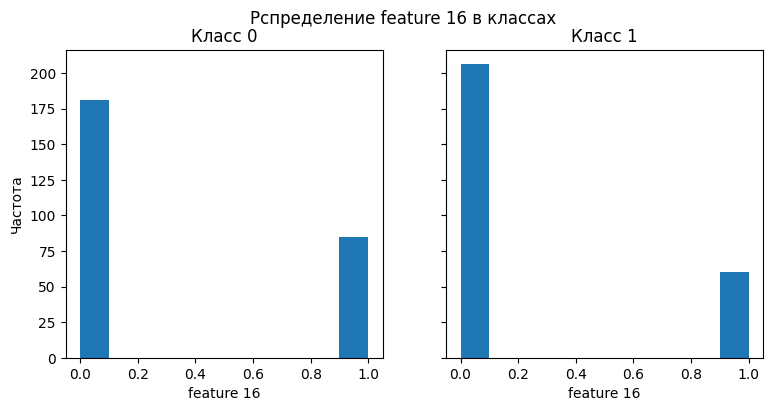

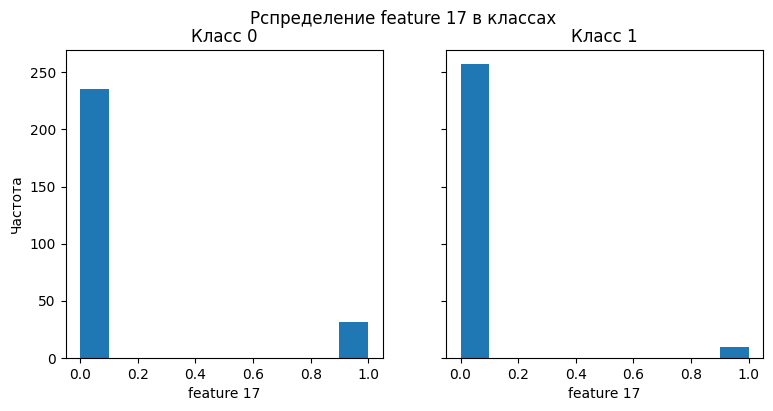

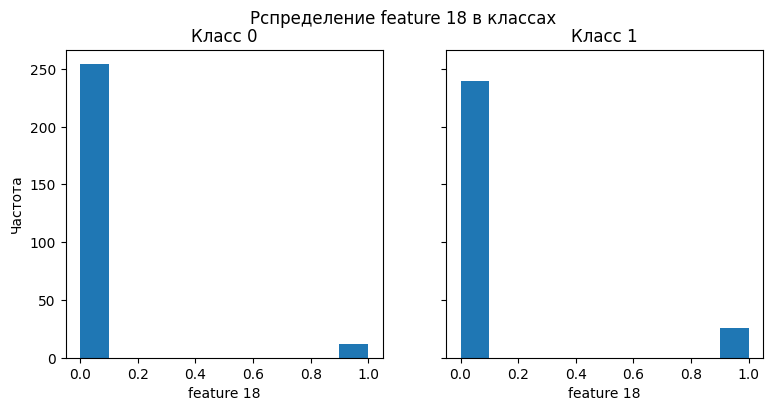

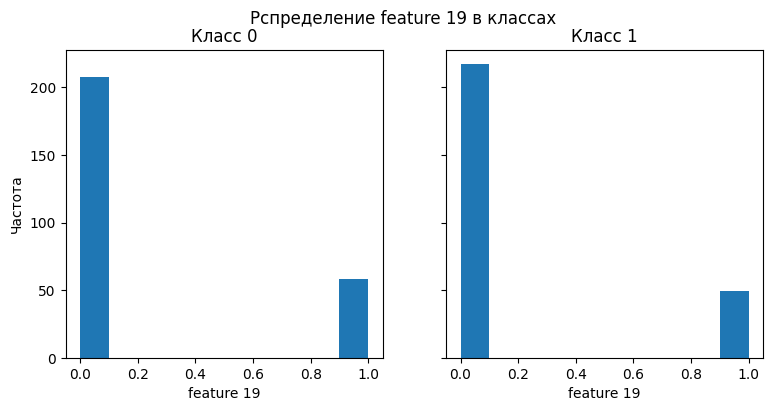

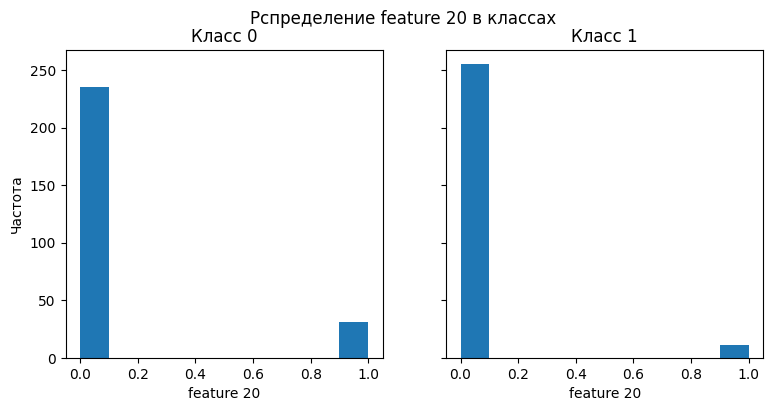

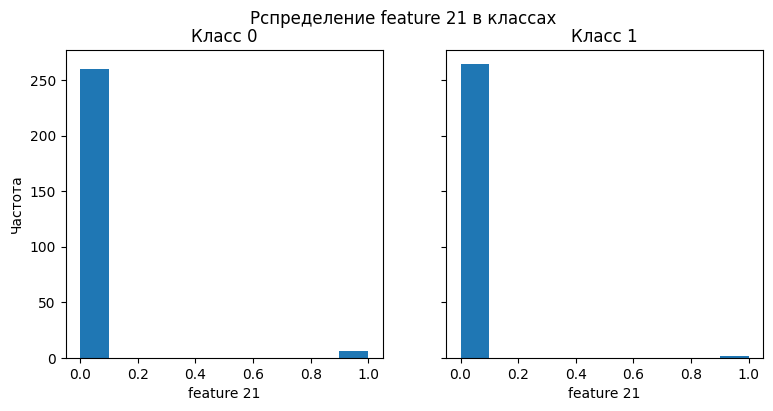

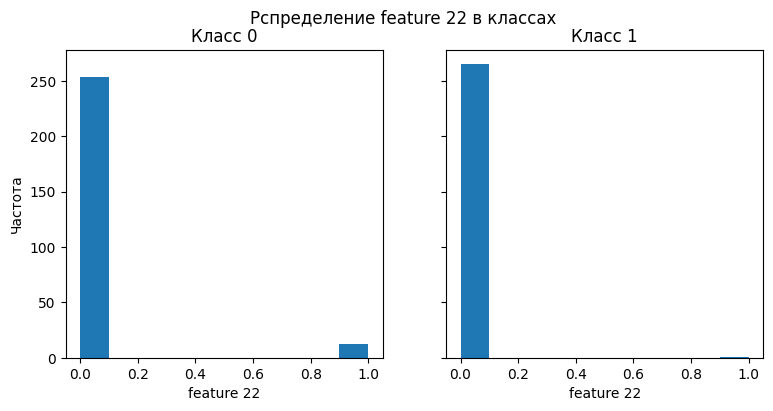

In [9]:
# Посмотрим на распределение признаков по классам
dict_feat = {}
for i, feature in enumerate(X.columns, start=1):
    dict_feat[f'feature {i}'] = feature

for feat_name, feat in dict_feat.items():
    fig, [ax0, ax1] = plt.subplots(figsize=(9, 4), ncols=2, sharey=True)
    fig.suptitle(f'Рспределение {feat_name} в классах')

    ax0.hist(data[feat][y==0])
    ax0.set_xlabel(feat_name)
    ax0.set_ylabel('Частота')
    ax0.set_title(f'Класс 0')

    ax1.hist(data[feat][y==1])
    ax1.set_xlabel(feat_name)
    ax1.set_title(f'Класс 1')

***Распределения признаков в классах схожи, не удалось явно выявить признак, который бы однозначно разделял классы***

# Modeling

In [10]:
# Разобьем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## LogisticRegression

In [11]:
model = LogisticRegression(random_state=42, class_weight='balanced')
param = {
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10]
}

model = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='precision',
    cv=skf
)
model.fit(X_train, y_train)

logreg = model.best_estimator_
print(f'Лучшая модель: {logreg}')

Лучшая модель: LogisticRegression(C=0.001, class_weight='balanced', random_state=42,
                   solver='liblinear')


In [12]:
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
y_train_proba = logreg.predict_proba(X_train)[:, 1]
y_test_proba = logreg.predict_proba(X_test)[:, 1]

print(f'Матрица ошибок на обучающей выборке:\n{confusion_matrix(y_train, y_train_pred)}')
print(f'Матрица ошибок на тесте:\n{confusion_matrix(y_test, y_test_pred)}')

Матрица ошибок на обучающей выборке:
[[153  59]
 [113 100]]
Матрица ошибок на тесте:
[[35 19]
 [29 24]]


## KNeighbours

In [13]:
model = KNeighborsClassifier()
param = {
    'n_neighbors': np.arange(1, 11),
    'weights': ['uniform', 'distance']
}

model = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='precision',
    cv=skf
)
model.fit(X_train, y_train)

knn = model.best_estimator_
print(f'Лучшая модель: {knn}')

Лучшая модель: KNeighborsClassifier(n_neighbors=4, weights='distance')


In [14]:
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
y_train_proba = knn.predict_proba(X_train)[:, 1]
y_test_proba = knn.predict_proba(X_test)[:, 1]

print(f'Матрица ошибок на обучающей выборке:\n{confusion_matrix(y_train, y_train_pred)}')
print(f'Матрица ошибок на тесте:\n{confusion_matrix(y_test, y_test_pred)}')

Матрица ошибок на обучающей выборке:
[[185  27]
 [ 48 165]]
Матрица ошибок на тесте:
[[28 26]
 [33 20]]


## DecisionTreeClassifier

In [15]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
param = {
    'max_depth': np.arange(1, 20),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'ccp_alpha': [0, 1, 5]
}

model = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='precision',
    cv=skf
)
model.fit(X_train, y_train)

dtc = model.best_estimator_
print(f'Лучшая модель: {dtc}')

Лучшая модель: DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced', max_depth=5,
                       random_state=42)


In [16]:
dtc.fit(X_train, y_train)

y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)
y_train_proba = dtc.predict_proba(X_train)[:, 1]
y_test_proba = dtc.predict_proba(X_test)[:, 1]

print(f'Матрица ошибок на обучающей выборке:\n{confusion_matrix(y_train, y_train_pred)}')
print(f'Матрица ошибок на тесте:\n{confusion_matrix(y_test, y_test_pred)}')

Матрица ошибок на обучающей выборке:
[[ 90 122]
 [ 32 181]]
Матрица ошибок на тесте:
[[23 31]
 [12 41]]


## SVC

In [17]:
model = SVC(class_weight='balanced', probability=True, random_state=42)
param = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.arange(1, 11)
}

model = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='precision',
    cv=skf
)
model.fit(X_train, y_train)

svc = model.best_estimator_
print(f'Лучшая модель: {svc}')

Лучшая модель: SVC(C=5, class_weight='balanced', probability=True, random_state=42)


In [18]:
svc.fit(X_train, y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
y_train_proba = svc.predict_proba(X_train)[:, 1]
y_test_proba = svc.predict_proba(X_test)[:, 1]

print(f'Матрица ошибок на обучающей выборке:\n{confusion_matrix(y_train, y_train_pred)}')
print(f'Матрица ошибок на тесте:\n{confusion_matrix(y_test, y_test_pred)}')

Матрица ошибок на обучающей выборке:
[[162  50]
 [ 28 185]]
Матрица ошибок на тесте:
[[24 30]
 [21 32]]


## RandomForestClassifier

In [19]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
param = {
    'n_estimators': [10, 30, 50, 70],
    'max_depth': np.arange(1, 11)
}

model = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='precision',
    cv=skf
)
model.fit(X_train, y_train)

rfc = model.best_estimator_
print(f'Лучшая модель: {rfc}')

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=10,
                       random_state=42)


In [20]:
rfc.fit(X_train, y_train)

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
y_train_proba = rfc.predict_proba(X_train)[:, 1]
y_test_proba = rfc.predict_proba(X_test)[:, 1]

print(f'Матрица ошибок на обучающей выборке:\n{confusion_matrix(y_train, y_train_pred)}')
print(f'Матрица ошибок на тесте:\n{confusion_matrix(y_test, y_test_pred)}')

Матрица ошибок на обучающей выборке:
[[138  74]
 [ 35 178]]
Матрица ошибок на тесте:
[[23 31]
 [23 30]]


## MLPClassifier

In [21]:
model = MLPClassifier(random_state=42)
param = {
    'hidden_layer_sizes': [(10, ), (20, ), (30, )],
    'activation':['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01]
}

model = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='precision',
    cv=skf
)
model.fit(X_train, y_train)

mlp = model.best_estimator_
print(f'Лучшая модель: {mlp}')

Лучшая модель: MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30,),
              random_state=42, solver='lbfgs')


In [22]:
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
y_train_proba = mlp.predict_proba(X_train)[:, 1]
y_test_proba = mlp.predict_proba(X_test)[:, 1]

print(f'Матрица ошибок на обучающей выборке:\n{confusion_matrix(y_train, y_train_pred)}')
print(f'Матрица ошибок на тесте:\n{confusion_matrix(y_test, y_test_pred)}')

Матрица ошибок на обучающей выборке:
[[181  31]
 [ 40 173]]
Матрица ошибок на тесте:
[[28 26]
 [26 27]]


# Сравнение моделей

In [23]:
# Посмотрим на основные метрики для разных моделей
models = [logreg, knn, dtc, svc, rfc, mlp]
di = {}
for i, model in enumerate(models, start=1):
    scores = [
        accuracy_score(y_test, model.predict(X_test)),
        precision_score(y_test, model.predict(X_test)),
        recall_score(y_test, model.predict(X_test)),
        roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    ]
    di[type(model).__name__] = scores

indexes = ['accuracy', 'precision', 'recall', 'roc_auc']
results = pd.DataFrame(di, index=indexes)

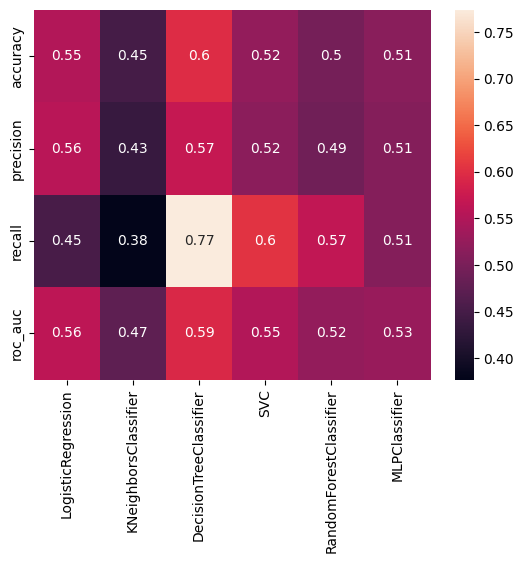

In [24]:
sns.heatmap(results, annot=True);

***Модель решающего дерева показывает лучшие метрики при решении задачи классификации***

In [25]:
# Обучим лучшую модель на всех данных и сохраним ее
final_model = dtc
final_model.fit(X, y)

with open('/final_model.pkl', 'wb') as file:
    dill.dump(final_model, file)

Рассмотрим 4 наиболее важных признака для этой модели

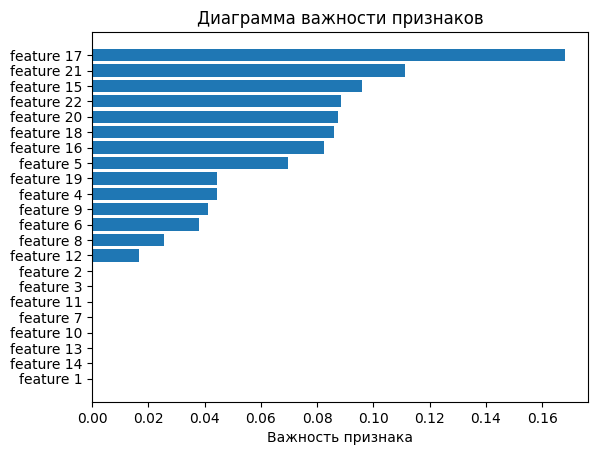

Самые важные признаки для модели решающего дерева:
1. За ответом на вопросы 10-14 просит обратиться к сотруднику
2. Офис находится в здании партнера/друга/родственника, аренду не платит.
3. Нерелевантный опыт работы
4. Заемщик от партнера и был подготовлен к ВИ


In [26]:
barh_data = pd.DataFrame({'feature': list(dict_feat.keys()), 'coef': dtc.feature_importances_})
barh_data.sort_values(by='coef', inplace=True)
plt.barh(barh_data['feature'], barh_data['coef'])
plt.xlabel('Важность признака')
plt.title('Диаграмма важности признаков')
plt.show()


print('Самые важные признаки для модели решающего дерева:')

for i, key in enumerate(barh_data['feature'][-1:-5:-1], start=1):
    print(f'{i}. {dict_feat[key]}')

Хоть мы и видим самые важные признаки, их взаимосвязь с каким-то конкретным классом не определена. Посмотрим на коэффиценты при признаках в модели логистической регрессии, чтобы определить, какие из них увеличивают вероятность выдачи займа, а какие - нет.

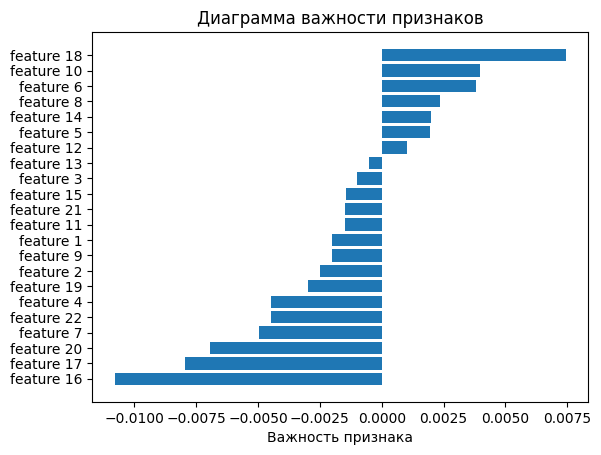

In [27]:
barh_data = pd.DataFrame({'feature': list(dict_feat.keys()), 'coef': logreg.coef_[0]})
barh_data.sort_values(by='coef', inplace=True)
plt.barh(barh_data['feature'], barh_data['coef'])
plt.xlabel('Важность признака')
plt.title('Диаграмма важности признаков')
plt.show()

# Выводы

Результаты визуализации коэффициентов при признаках в модели логистической регресии согласуются с логическими выводами, а именно:
1. Наличие нерелевантного опыты уменьшает вероятность выдачи займа.
2. Нелогичный выбор сферы бизнеса уменьшает вероятность выдачи займа.
3. Если заемщик просит обратиться к сотруднику за ответом на вопросы 10-14, то это уменьшает вероятность выдачи займа.
4. Если текущее ЮЛ основано до 30 лет, то это увеливает верятность выдачи займа.

Однако стоит отменить, что признак под номером 3 необходимо рассмотреть подробнее, а именно узнать, что за ним скрывается (какие вопросы), чтобы экспертно судить о корректности его важности.

Для увеличение экономической прибыли можно попробовать выдавать займы преимущественно тем, у кого приведенные выше факторы этому соответствуют, т.е. если:
1. Нет наличия нерелевантного опыта.
2. Выбор сферы бизнеса логичен.
3. ЮЛ основано до 30 лет.